# Monte Carlo Control with exploration starts

In [25]:
%matplotlib notebook

In [2]:
from blackjack import BlackJack
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

random.seed(1234)
np.random.seed(1234)

In [3]:
game = BlackJack()
game_test = BlackJack()
epochs = 500_000
test_epochs = 100_000
#alpha = .1

actions = ["hit", "stand", "double"]

# intialize Q(s,a) = 0, pi(s) = random a, N(s) = 0
Q = {state : {a : 0 for a in actions} for state in game.states} # Q values
pi = {state : random.choice(actions) for state in game.states} # policy
N = {state : 0 for state in game.states} # number of times states are visited
rewards = [0] * (epochs+1)
stats = []

New BlackJack game created
New BlackJack game created


In [4]:
for i in range(epochs+1):
    
    if i % (epochs / 100) == 0:
        #print(i)
        stats.append(np.unique(game_test.test_policy(pi, test_epochs), return_counts = True)[1])
    
    #game.start() # sample all states with probabilities proportional to the frequency of their occurence in a simulated game
    game.start_from_state(random.choice(game.states)) # sample all states uniformly
    
    first = True
    
    visited_states = []
    performed_actions = []
    
    while game.player_hand_sum < 21: # while the player hasn't busted
        
        state = game.get_current_state()
        
        action = pi[state] # greedy policy
        
        # if the state is first in the trajectory, the action is random
        # that facilitates exploration starts
        if first:
            action = random.choice(actions)
            first = False
        
        visited_states.append(state)
        performed_actions.append(action)
        
        if action == "hit":
            game.hit()
        elif action == "stand":
            game.stand() # if we stand, the round ends
            break
        else:
            game.double() # if we double, the round ends because double = hit -> stand
            break
    
    # store reward
    reward = game.get_reward()
    rewards[i] = reward
    
    # update Q
    for s, a in zip(visited_states, performed_actions):
        
        N[s] += 1 # count occurences of states
        
        # update the Q-value
        Q[s][a] += (reward - Q[s][a]) / N[s] # Q-value = mean of all returns 
        #Q[s][a] += alpha * (reward - Q[s][a]) # incremental update; recently observed returns are more valuable
        
    # update the policy
    for s in visited_states:
        
        pi[s] = max(Q[s], key = Q[s].get)
    

In [5]:
np.save("data/LearningRate/MonteCarloControlWithExploringStartsLR", stats)

In [6]:
rewards = game.test_policy(pi, 1_000_000, verbose = 1)

Winrate: 0.4303072763495783
Drawrate: 0.08353133816872456
Loserate: 0.48616138548169713
Ws: 475391; Ls: 537097; Draws: 92283
Profit: -62684
Wins after doubling: 18977; Losses after doubling: 19753


In [7]:
rewards_freq = np.unique(rewards, return_counts = True)[1]
np.save("data/FinalEvaluation/MonteCarloControlWithExploringStartsFinal", rewards_freq)

Below this are some plotting attempts

In [8]:
df = pd.DataFrame(list(pi.keys()), columns = ["player_hand_sum", "has_usable_ace", "dealer_visible_card"])
df["V"] = [Q[state][pi[state]] for state in pi]
df["action"] = pi.values()
df.head()

,player_hand_sum,has_usable_ace,dealer_visible_card,V,action
0,16,False,1,-0.509134,hit
1,13,True,2,-0.009965,hit
2,18,True,6,0.266197,stand
3,20,True,7,0.722911,stand
4,19,False,9,0.261457,stand


In [45]:
df.to_csv("data/Policies/MCCwithESpolicy")

In [21]:
with_ace = df[df["has_usable_ace"]].drop("has_usable_ace", axis = "columns")
no_ace = df[~df["has_usable_ace"]].drop("has_usable_ace", axis = "columns")

with_ace['color'] = with_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})
no_ace['color'] = no_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})

<IPython.core.display.Javascript object>


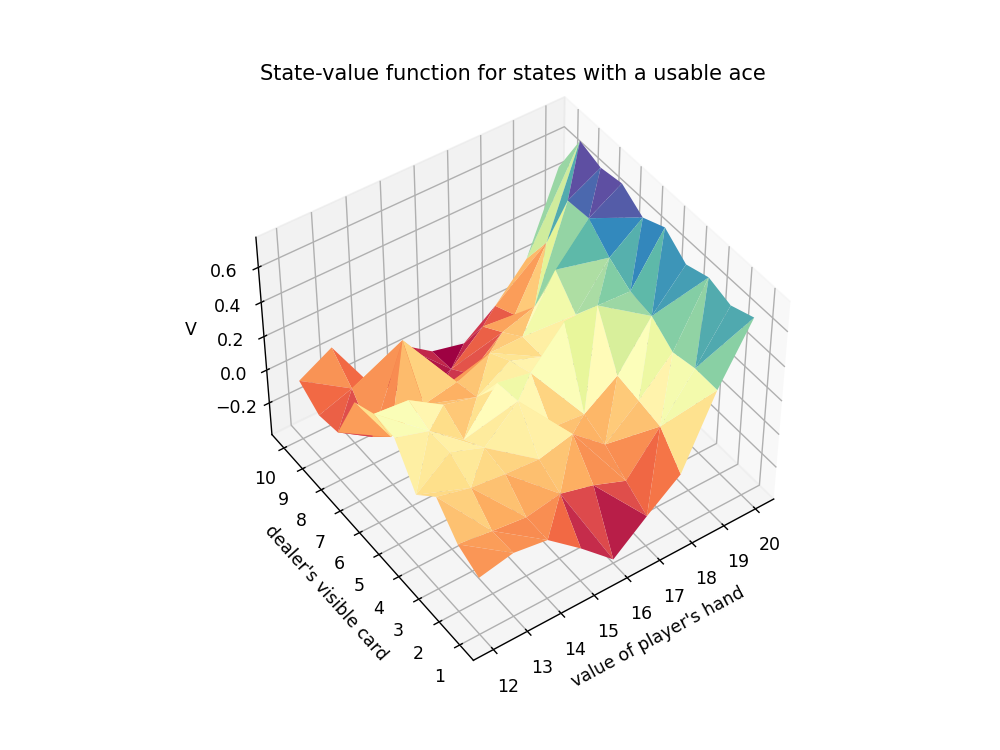

In [44]:
ax = plt.axes(projection='3d')

ax.plot_trisurf(with_ace["player_hand_sum"], with_ace["dealer_visible_card"], with_ace["V"], cmap=plt.cm.Spectral)

ax.set_title("State-value function for states with a usable ace")
ax.set_xlabel("value of player's hand")
ax.set_ylabel("dealer's visible card")
ax.set_xticks(np.arange(12,21))
ax.set_yticks(np.arange(1,11))
ax.set_zlabel("V")
ax.view_init(45, 235)
#plt.savefig("pic.pdf")

plt.show()

In [24]:
ax = plt.axes(projection='3d')

ax.plot_trisurf(no_ace["player_hand_sum"], no_ace["dealer_visible_card"], no_ace["V"], cmap=plt.cm.Spectral)

ax.set_title("State-value function for states without a usable ace")
ax.set_xlabel("value of player's hand")
ax.set_ylabel("dealer's visible card")
ax.set_xticks(np.arange(12,21))
ax.set_yticks(np.arange(1,11))
ax.set_zlabel("V")
plt.show()

In [23]:
plt.scatter(with_ace["player_hand_sum"], with_ace["dealer_visible_card"], 
            c = with_ace["color"], marker="s", s = 720)
plt.yticks(np.arange(1,11))
plt.xlabel("Value of player's hand")
plt.ylabel("Dealer's visible card")
plt.title("Learned policy for states with a usable ace")

legend_elements = [Line2D([0], [0], marker='s', color='w', label='hit', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='stand', markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='double', markerfacecolor='green', markersize=15)]

plt.legend(handles=legend_elements, title = "action", bbox_to_anchor=(1, 1))
plt.axis("scaled")
plt.tight_layout()
plt.xticks(np.arange(12,21))
plt.show()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

<IPython.core.display.Javascript object>


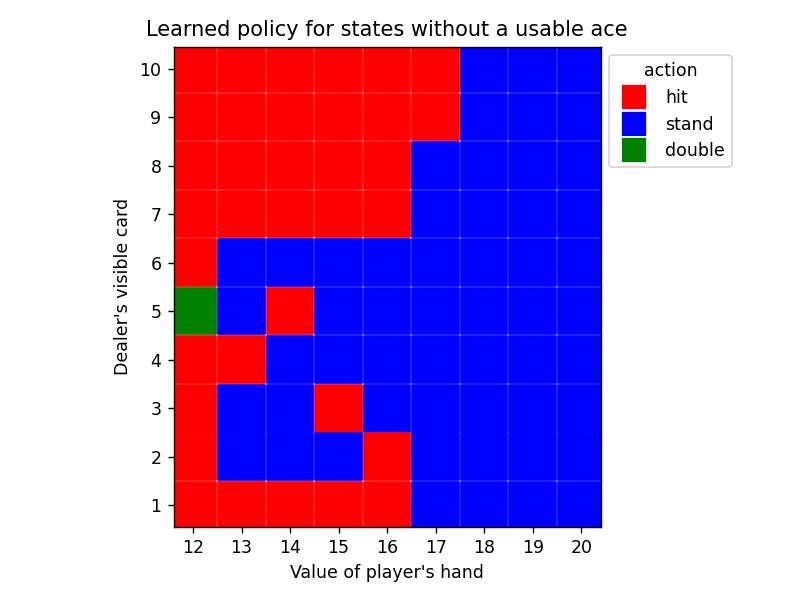

In [65]:
plt.scatter(no_ace["player_hand_sum"], no_ace["dealer_visible_card"], 
            c = no_ace["color"], marker="s", s = 720)
plt.yticks(np.arange(1,11))
plt.xlabel("Value of player's hand")
plt.ylabel("Dealer's visible card")
plt.title("Learned policy for states without a usable ace")

legend_elements = [Line2D([0], [0], marker='s', color='w', label='hit', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='stand', markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='double', markerfacecolor='green', markersize=15)]

plt.legend(handles=legend_elements, title = "action", bbox_to_anchor=(1, 1))
plt.axis("scaled")
plt.tight_layout()
plt.xticks(np.arange(12,21))
plt.savefig("pic.pdf")
plt.show()